In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import shutil
import random
import seaborn as sns
import datetime 

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from keras.regularizers import l1, l2, l1_l2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, CSVLogger, ModelCheckpoint
from tensorflow.keras.models import load_model    
from tensorflow.keras.metrics import AUC


Using TensorFlow backend.


In [2]:
# utilities

def plot_cm(true,pred):
    cm=confusion_matrix(true,pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax=sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.set(xlabel='Prediction', ylabel='Class')
    return ax
#plot_cm(test_ds.classes, test_predict_classes)

# plot train/val accuracy
def plot_accuracy(history):
    ax=plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
#plot_accuracy(history)

# plot train/val recall
def plot_recall(history):
    ax=plt.figure()
    plt.plot(history.history['recall'])
    plt.plot(history.history['val_recall'])
    plt.title('Model Recall')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
#plot_accuracy(history)

# plot train/val recall
def plot_precision(history):
    ax=plt.figure()
    plt.plot(history.history['precision'])
    plt.plot(history.history['val_precision'])
    plt.title('Model Precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')
    
# plot train/val recall
def plot_loss(history):
    ax=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='best')

# evaluate and plot ROC
def plot_roc(y_true, score, return_pos_rate=False):
    fpr, tpr, threshold=roc_curve(y_true,score)
    roc_auc=auc(fpr, tpr)
    ax=plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="best")
    if return_pos_rate==True:
        return ax, pd.DataFrame({'threshold':threshold, 'True Positive Rate':tpr, 'False Positive Rate':fpr})
    
#q=plot_roc(test_ds.classes, test_predict)

def ImageGenerators(path_train, path_val, path_test):
    
    train_datagen=ImageDataGenerator(rescale=1./255)
    train_ds=train_datagen.flow_from_directory(
        path_train,  
        class_mode='binary',
        #subset="training", 
        seed=11, 
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        classes=['Non-cracked','Cracked_aug'])

    val_datagen=ImageDataGenerator(rescale=1./255)
    val_ds=val_datagen.flow_from_directory(
        path_val,  
        class_mode='binary',
        #subset="validation", 
        seed=11, 
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        classes=['Non-cracked','Cracked'])

    test_datagen=ImageDataGenerator(rescale=1./255)

    test_ds=test_datagen.flow_from_directory(
        path_test, 
        class_mode='binary',
        seed=11, 
        target_size=(img_height, img_width), 
        batch_size=batch_size,
        classes=['Non-cracked','Cracked'],
        shuffle=False)
    return train_ds, val_ds, test_ds

class MetricsHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.accuracy= []
        self.precision=[]
        self.recall=[]

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))
        self.precision.append(logs.get('precision'))
        self.recall.append(logs.get('recall'))
metrics_history = MetricsHistory()

def CreateHistoryDF(cnn_params, history, test_eval):
    history_df=pd.DataFrame(history.history)
    params_s=pd.Series(cnn_params)
    history_df = history_df.merge(pd.DataFrame(data = [params_s.values] * history_df.shape[0], columns = params_s.index), left_index=True, right_index=True)
    test_s=pd.Series(test_eval, index = ['test_loss','test_accuracy','test_recall','test_precision'])
    history_df=history_df.merge(pd.DataFrame(data = [test_s.values] * history_df.shape[0], columns = test_s.index),left_index=True, right_index=True)
    history_df['f_score']=2*history_df.precision*history_df.recall/(history_df.precision+history_df.recall)
    history_df['val_f_score']=2*history_df.val_precision*history_df.val_recall/(history_df.val_precision+history_df.val_recall)
    history_df['test_f_score']=2*history_df.test_precision*history_df.test_recall/(history_df.test_precision+history_df.test_recall)
    return(history_df)

def PlotWrongPredictions(prediction, pavements_test, n_images=50,nx=5,ny=10):
    
    test_pred_classes=[1 if i>0.5 else 0 for i in prediction]
    wrong_prediction_index=[]
    for position, value in enumerate(test_pred_classes):
        if value != pavements_test.classes[position]:
            wrong_prediction_index.append(position)
    
    img_n_rows=n_images//nx+1        
    image_idx=0
    plt.figure(figsize=(nx*4, ny*8))
    for idx in wrong_prediction_index:
        if image_idx<n_images:
            image=pavements_test[int(idx//batch_size)][0][int((idx/batch_size-idx//batch_size)*batch_size)]
            plt.subplot(20, 5, image_idx + 1)
            #plt.subplots(img_n_rows,5, image_idx)
            plt.imshow(image)
            plt.title('Class:' + str(pavements_test.classes[idx]) +'\n'+'Prediction:' + str(np.round(prediction[idx][0],2)))
            plt.xticks([])
            plt.yticks([])
            image_idx+=1    
    plt.show()
    
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


In [3]:
# Image Generators
batch_size = 128
img_height = 256 #224
img_width = 256 #224
#root='/storage/Crack_detection/Dataset2/Dataset2' #free machine
root='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/' #paid machine
pavements_train=os.path.join(root, 'Pavements','Train')
pavements_val=os.path.join(root, 'Pavements','Validation')
pavements_test=os.path.join(root, 'Pavements','Test')
pavements_train, pavements_val, pavements_test=ImageGenerators(pavements_train,pavements_val, pavements_test)

Found 36942 images belonging to 2 classes.
Found 2432 images belonging to 2 classes.
Found 2432 images belonging to 2 classes.


In [4]:
def cnn5_model2(fc1_n=512, fc2_n=64, dp_cnn1=0.1, dp_cnn2=0.1, dp_cnn3=0.2, dp_cnn4=0.2, dp_cnn5=0.2, dp_fc1=0.3, dp_fc2=0.3, l2_reg=0):
    
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3),kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn1))

    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn2))

    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn3))

    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn4))

    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn5))

    model.add(Flatten())
    
    model.add(Dense(fc1_n, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Dropout(dp_fc1))
    
    if fc2_n>0:
        model.add(Dense(fc2_n, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
        model.add(Dropout(dp_fc2))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(img_height, img_width, 3))
        
    return model

### Baseline model: 5 CNN layers - Dropout = 0.2, 1 FullyConnected layer (100 nodes)  - Dropout = 0.3, L2 regularization for both CNN & FC = 1e-3

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

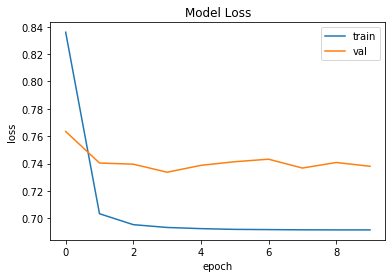

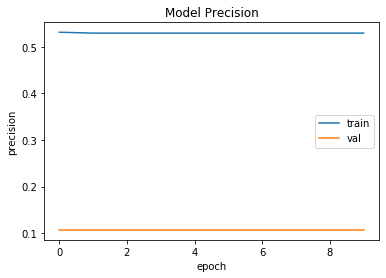

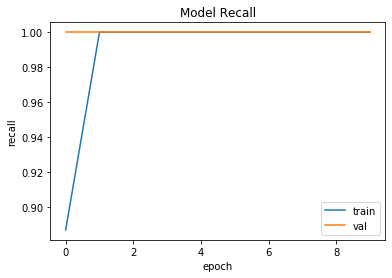

In [20]:
model_name='model2_dp2_dp3_1fcl_l2p001_020121'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.2, 'dp_cnn2':0.2, 'dp_cnn3':0.2, 'dp_cnn4':0.2, 'dp_cnn5':0.2, 'dp_fc1':0.3, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['accuracy', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

### 5 CNN layers - Dropout = 0.1, 1 FullyConnected layer (100 nodes) - Dropout = 0.2, L2 regularization for both CNN & FC = 1e-3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)       

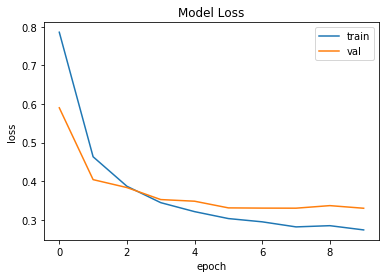

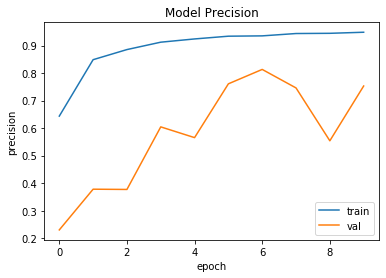

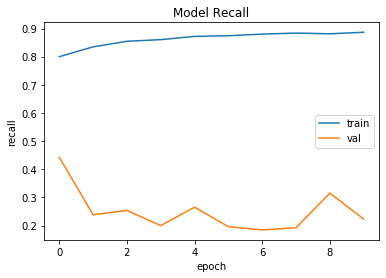

In [9]:
model_name='model2_dp1_dp2_1fcl_l2p001_020121'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.1, 'dp_cnn2':0.1, 'dp_cnn3':0.1, 'dp_cnn4':0.1, 'dp_cnn5':0.1, 'dp_fc1':0.2, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

[0.06924518942832947]


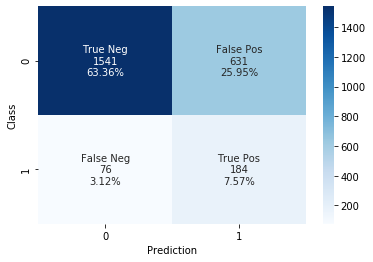

In [16]:
#evaluate on test data
test_pred=model.predict(pavements_test)
threshold = Find_Optimal_Cutoff(pavements_test.classes, test_pred)
print(threshold)
test_pred_classes=[1 if i>threshold else 0 for i in test_pred]
plot_cm(pavements_test.classes, test_pred_classes)

### 5 CNN layers - Dropout = 0.1, 1 FullyConnected layer (100 nodes) - Dropout = 0.25, L2 regularization for both CNN & FC = 1e-3

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)       

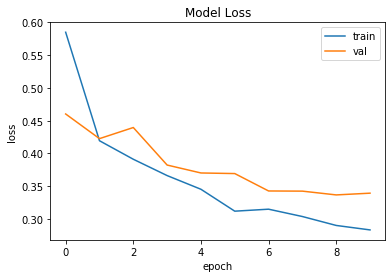

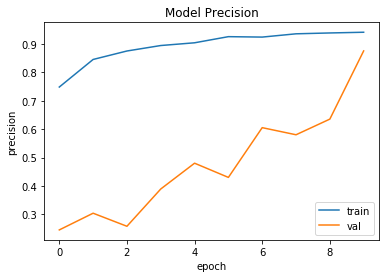

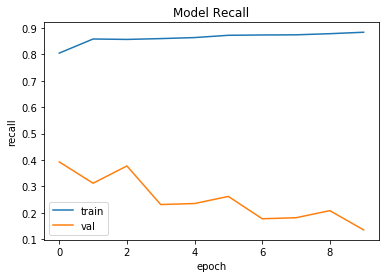

In [7]:
model_name='model2_dp1_dp25_1fcl_l2p001_020121'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.1, 'dp_cnn2':0.1, 'dp_cnn3':0.1, 'dp_cnn4':0.1, 'dp_cnn5':0.1, 'dp_fc1':0.25, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

[0.07546281814575195]


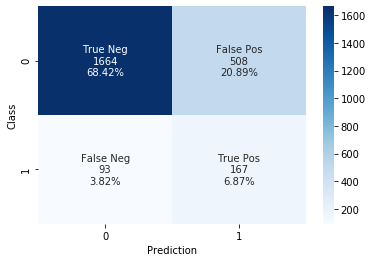

In [8]:
#evaluate on test data
test_pred=model.predict(pavements_test)
threshold = Find_Optimal_Cutoff(pavements_test.classes, test_pred)
print(threshold)
test_pred_classes=[1 if i>threshold else 0 for i in test_pred]
plot_cm(pavements_test.classes, test_pred_classes)

### 5 CNN layers - No Dropout, 1 FullyConnected layer (100 nodes) - Dropout = 0.2, L2 regularization for both CNN & FC = 1e-3

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 64)       

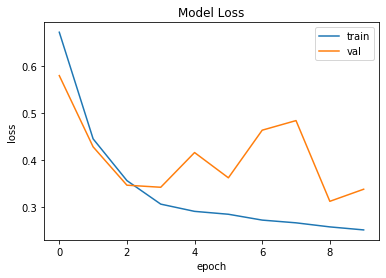

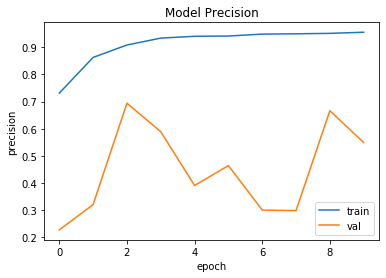

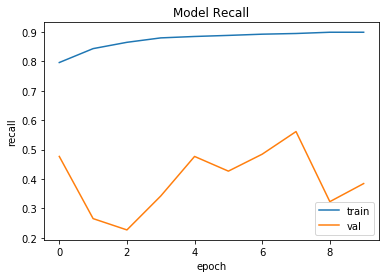

In [9]:
model_name='model2_dp0_dp2_1fcl_l2p001_020221'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0, 'dp_cnn2':0, 'dp_cnn3':0, 'dp_cnn4':0, 'dp_cnn5':0, 'dp_fc1':0.2, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

[0.06402567028999329]


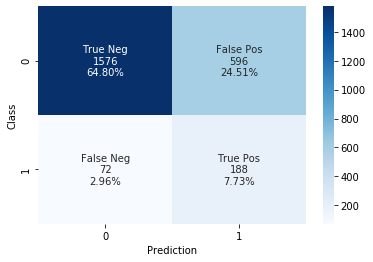

In [10]:
#evaluate on test data
test_pred=model.predict(pavements_test)
threshold = Find_Optimal_Cutoff(pavements_test.classes, test_pred)
print(threshold)
test_pred_classes=[1 if i>threshold else 0 for i in test_pred]
plot_cm(pavements_test.classes, test_pred_classes)

### 5 CNN layers - No Dropout, 1 FullyConnected layer (100 nodes) - Dropout = 0.2, L2 regularization for both CNN & FC = 1e-3, Batch size =512

Found 36942 images belonging to 2 classes.
Found 2432 images belonging to 2 classes.
Found 2432 images belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 62, 62, 32)        0   

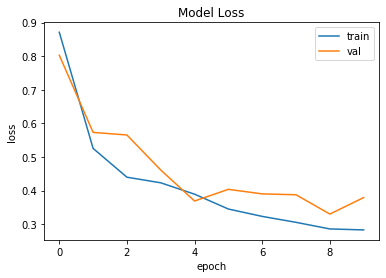

In [11]:
# Image Generators
batch_size = 512 #128
img_height = 256 
img_width = 256 
root='/storage/Crack_detection/Dataset2/Crack_detection/Dataset2/' #paid machine
pavements_train=os.path.join(root, 'Pavements','Train')
pavements_val=os.path.join(root, 'Pavements','Validation')
pavements_test=os.path.join(root, 'Pavements','Test')
pavements_train, pavements_val, pavements_test=ImageGenerators(pavements_train,pavements_val, pavements_test)

model_name='model2_dp0_dp2_1fcl_l2p001_B512_020221'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0, 'dp_cnn2':0, 'dp_cnn3':0, 'dp_cnn4':0, 'dp_cnn5':0, 'dp_fc1':0.2, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
#plot_precision(history)
#plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

### 5 CNN layers - Dropout = 0.1, 1 FullyConnected layer (100 nodes) - Dropout = 0.2, L2 regularization for both CNN & FC = 1e-3, learning_rate=1e-2

In [6]:
model_name='model2_dp1_dp2_1fcl_l2p001_lr1e-2_020221'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.1, 'dp_cnn2':0.1, 'dp_cnn3':0.1, 'dp_cnn4':0.1, 'dp_cnn5':0.1, 'dp_fc1':0.2, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)       

KeyboardInterrupt: 

### 5 CNN layers - Dropout = 0.1, 1 FullyConnected layer (100 nodes) - Dropout = 0.2, L2 regularization for both CNN & FC = 1e-3, learning_rate=5e-4

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 60, 60, 64)       

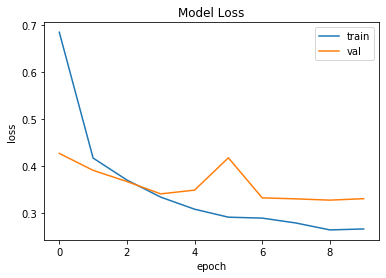

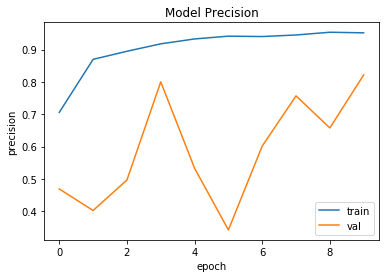

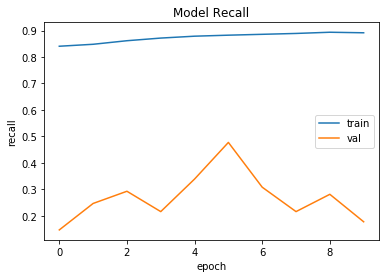

In [8]:
model_name='model2_dp1_dp2_1fcl_l2p001_lr5e-4_020221'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/Crack_detection/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/Crack_detection/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.1, 'dp_cnn2':0.1, 'dp_cnn3':0.1, 'dp_cnn4':0.1, 'dp_cnn5':0.1, 'dp_fc1':0.2, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

[0.05021461844444275]


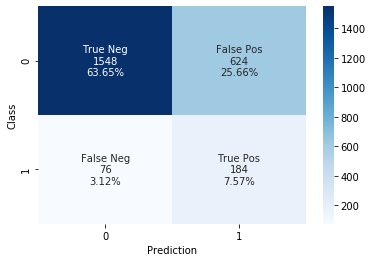

In [9]:
#evaluate on test data
test_pred=model.predict(pavements_test)
threshold = Find_Optimal_Cutoff(pavements_test.classes, test_pred)
print(threshold)
test_pred_classes=[1 if i>threshold else 0 for i in test_pred]
plot_cm(pavements_test.classes, test_pred_classes)

In [13]:
history_file_name='/Crack_detection/Crack_detection/opt2/'+'summary_'+model_name+'csv'
history_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+'summary_'+model_name+'csv'
history_df.to_csv(history_file_name, index=False)
model_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'.h5'
model.save(model_file_name)

### 5 CNN layers - Dropout = 0.05, 1 FullyConnected layer (100 nodes) - Dropout = 0.15, L2 regularization for both CNN & FC = 1e-3

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

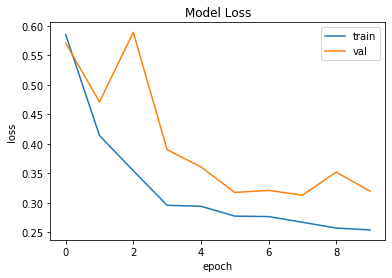

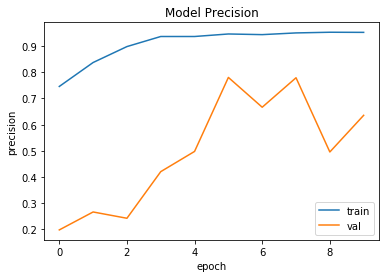

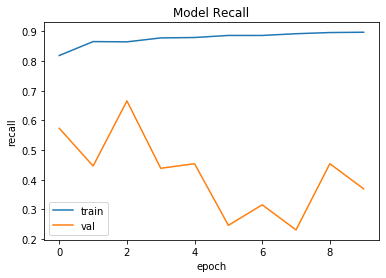

In [5]:
model_name='model2_dp05_dp2_1fcl_l2p001_020121'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.05, 'dp_cnn2':0.05, 'dp_cnn3':0.05, 'dp_cnn4':0.05, 'dp_cnn5':0.05, 'dp_fc1':0.15, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

[0.08886420726776123]


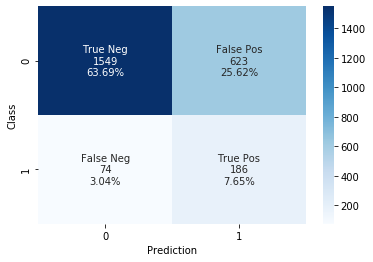

In [6]:
#evaluate on test data
test_pred=model.predict(pavements_test)
threshold = Find_Optimal_Cutoff(pavements_test.classes, test_pred)
print(threshold)
test_pred_classes=[1 if i>threshold else 0 for i in test_pred]
plot_cm(pavements_test.classes, test_pred_classes)

### 5 CNN layers - Dropout = 0.05, 1 FullyConnected layer (100 nodes) - Dropout = 0.1, L2 regularization for both CNN & FC = 1e-3

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

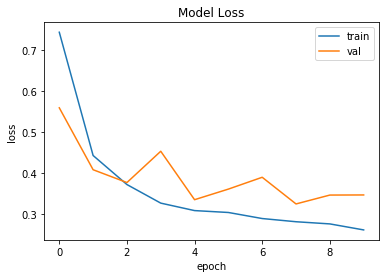

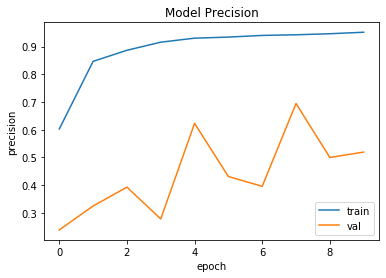

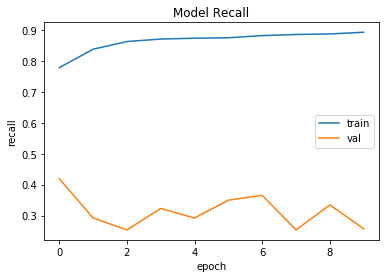

In [5]:
model_name='model2_dp05_dp1_1fcl_l2p001_020421'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.05, 'dp_cnn2':0.05, 'dp_cnn3':0.05, 'dp_cnn4':0.05, 'dp_cnn5':0.05, 'dp_fc1':0.1, 'dp_fc2':0.3, 'l2_reg':1e-3}
model=cnn5_model2(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

[0.07477882504463196]


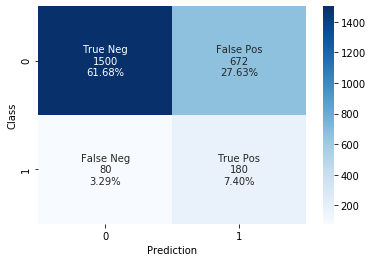

In [6]:
#evaluate on test data
test_pred=model.predict(pavements_test)
threshold = Find_Optimal_Cutoff(pavements_test.classes, test_pred)
print(threshold)
test_pred_classes=[1 if i>threshold else 0 for i in test_pred]
plot_cm(pavements_test.classes, test_pred_classes)

### 5 CNN layers, 1 FullyConnected layer (100 nodes),L2 regularization for both CNN & FC = 1e-3 and w/ BatchNormalization, no Dopout

In [7]:
# Batch Normalization, no Dropout
def cnn5_model3(fc1_n=512, fc2_n=64, dp_cnn1=0.1, dp_cnn2=0.1, dp_cnn3=0.2, dp_cnn4=0.2, dp_cnn5=0.2, dp_fc1=0.3, dp_fc2=0.3, l2_reg=0):
    
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3),kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Flatten())
    
    model.add(Dense(fc1_n, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    
    if fc2_n>0:
        model.add(Dense(fc2_n, activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(img_height, img_width, 3))
        
    return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 16)      64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 64)       

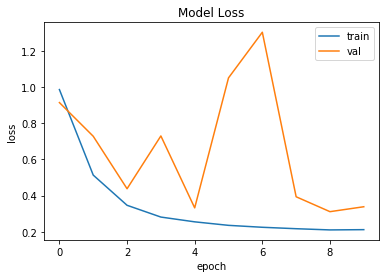

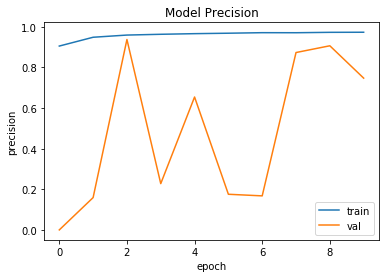

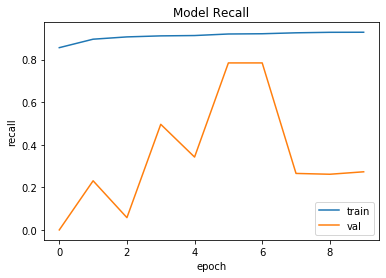

In [8]:
model_name='model3_1fcl_l2p001_020321'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.0, 'dp_cnn2':0.0, 'dp_cnn3':0.0, 'dp_cnn4':0.0, 'dp_cnn5':0.0, 'dp_fc1':0.0, 'dp_fc2':0.0, 'l2_reg':1e-3}
model=cnn5_model3(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

### 5 CNN layers - Dropout = 0.05, 1 FullyConnected layer (100 nodes) - Dropout = 0.15,L2 regularization for both CNN & FC = 1e-3 and w/ BatchNormalization (CNN-> BatchNorm -> ReLu -> MaxPool -> Dropout)

In [17]:
# Batch Normalization -> ReLu -> no Dropout
def cnn5_model4(fc1_n=512, fc2_n=64, dp_cnn1=0.1, dp_cnn2=0.1, dp_cnn3=0.2, dp_cnn4=0.2, dp_cnn5=0.2, dp_fc1=0.3, dp_fc2=0.3, l2_reg=0):
    
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), input_shape=(img_height, img_width, 3),kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activations.relu))  
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn1))

    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn2))
    
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn3))

    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn4))

    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn5))

    model.add(Flatten())
    
    model.add(Dense(fc1_n, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(Activation(activations.relu))    
    model.add(Dropout(dp_cnn1))
    
    if fc2_n>0:
        model.add(Dense(fc2_n, kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
        model.add(BatchNormalization())
        model.add(Activation(activations.relu))    
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(dp_cnn1))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(img_height, img_width, 3))
        
    return model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 254, 254, 16)      64        
_________________________________________________________________
activation (Activation)      (None, 254, 254, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 125, 125, 32)     

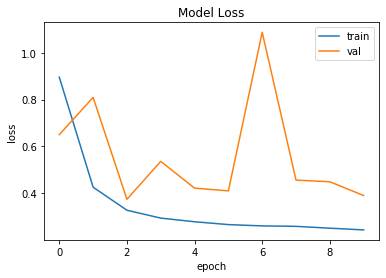

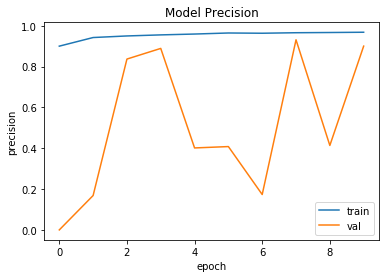

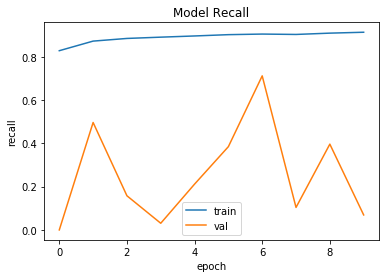

In [18]:
model_name='model4_BN_dp05_dp15_1fcl_l2p001_020321'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.05, 'dp_cnn2':0.05, 'dp_cnn3':0.05, 'dp_cnn4':0.05, 'dp_cnn5':0.05, 'dp_fc1':0.15, 'dp_fc2':0.0, 'l2_reg':1e-3}
model=cnn5_model4(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)

### 5 CNN layers - Dropout = 0.05, 1 FullyConnected layer (100 nodes) - Dropout = 0.15,L2 regularization for both CNN & FC = 1e-3 and w/ BatchNormalization (CNN -> ReLu -> MaxPool -> Dropout -> BatchNorm )

In [19]:
# Batch Normalization -> ReLu -> no Dropout
def cnn5_model5(fc1_n=512, fc2_n=64, dp_cnn1=0.1, dp_cnn2=0.1, dp_cnn3=0.2, dp_cnn4=0.2, dp_cnn5=0.2, dp_fc1=0.3, dp_fc2=0.3, l2_reg=0):
    
    model=Sequential()

    model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=(img_height, img_width, 3),kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn1))
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn2))
    model.add(BatchNormalization())
    
    model.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn3))
    model.add(BatchNormalization())

    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Activation(activations.relu))    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn4))
    model.add(BatchNormalization())
    
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), activation='relu', kernel_regularizer=l2(l2_reg), bias_regularizer=l2(l2_reg)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(dp_cnn5))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(fc1_n, kernel_regularizer=l2(l2_reg), activation='relu', bias_regularizer=l2(l2_reg))) 
    model.add(Dropout(dp_cnn1))
    model.add(BatchNormalization())
    
    if fc2_n>0:
        model.add(Dense(fc2_n, kernel_regularizer=l2(l2_reg), activation='relu', bias_regularizer=l2(l2_reg)))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(Dropout(dp_cnn1))
        model.add(BatchNormalization())

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.build(input_shape=(img_height, img_width, 3))
        
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 127, 127, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 127, 16)      64        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
activation_6 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)       

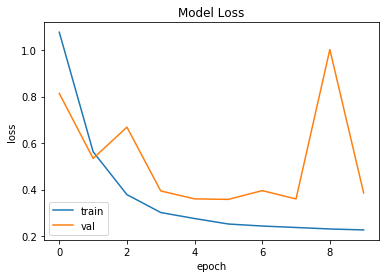

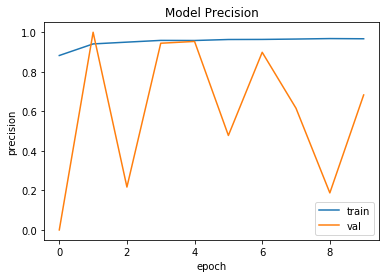

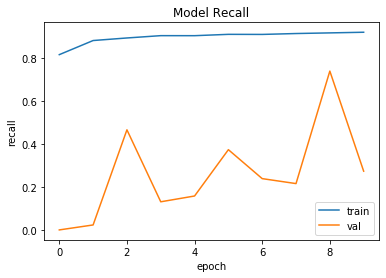

In [20]:
model_name='model5_BN_dp05_dp15_1fcl_l2p001_020321'
path='/Crack_detection/Crack_detection/'
model_file_name_callback='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'_training.h5'
model_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+model_name+'.h5'
history_file_name='/storage/Crack_detection/Dataset2/Crack_detection/opt2/'+'summary_'+model_name+'csv'

cnn_params={'fc1_n':100, 'fc2_n':0, 'dp_cnn1':0.05, 'dp_cnn2':0.05, 'dp_cnn3':0.05, 'dp_cnn4':0.05, 'dp_cnn5':0.05, 'dp_fc1':0.15, 'dp_fc2':0.0, 'l2_reg':1e-3}
model=cnn5_model5(**cnn_params)
model.summary()

model.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
             metrics=['AUC', 'Recall', 'Precision'])

checkpoint = ModelCheckpoint(model_file_name_callback, monitor='val_loss', verbose=1, mode='auto', period=1)

history=model.fit(
    pavements_train,
    validation_data=pavements_val,
    #class_weight={0:1, 1:10},
    callbacks=[checkpoint],
    epochs=10
)

plot_loss(history)
plot_precision(history)
plot_recall(history)

test_eval=model.evaluate(pavements_test)
history_df=CreateHistoryDF(cnn_params, history, test_eval)

model.save(model_file_name)
history_df.to_csv(history_file_name, index=False)